In [13]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import time
import datetime
from sklearn.preprocessing import MinMaxScaler
import IPython
import os
import math
%matplotlib inline

In [14]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

In [15]:
#import the data
orig_data = pd.read_csv('bank.csv')

In [16]:
#retaining the original data as-is
df = orig_data.copy()

# EDA

## Understanding the data

In [17]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Looking at the above, below columns are not required for the Model

* RowNumber
* CustomerId
* Surname

Hence dropping these columns

In [18]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [20]:
df.shape

(10000, 11)

## Checking for Missing values

In [21]:
print(f"Number of null values - {df.isnull().sum().sum()}, Number of NA values = {df.isna().sum().sum()}")

Number of null values - 0, Number of NA values = 0


## Converting Categorical variables to Integers (dummies)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Geography and Gender columns are categorical and hence in object datatype. 

Creating dummies for the same and converting them to int64 datatype

In [23]:
df = pd.get_dummies(data=df, columns=['Geography', 'Gender'], drop_first=True)

In [24]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


2 new dummies created for Geography and 1 for Gender column

Ensured that the dummies created are for n-1 different values by using drop_first attribute

##### Converting the datatype of the dummies created as well to int64

In [25]:
for column in df.columns:
    if column.startswith('Geography') or column.startswith('Gender'):
        df[column].astype('int64')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


## Splitting the Independent and Dependent variables

In [27]:
#Storing the independent variable names separately
independent_variables = []
for column in df.columns:
    if column!='Exited':
        independent_variables.append(column)
        

In [28]:
X = df[independent_variables]

In [29]:
y = df['Exited']

In [30]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [31]:
y = pd.DataFrame(data=y, columns=['Exited'])

In [32]:
y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


## Normalize the data

Using MinMax Scalar to make sure that the dummies created still remain with 0's and 1's.

In [33]:
def scale_independent_variables(X):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(data=X, columns=independent_variables)
    return X

In [34]:
X = scale_independent_variables(X)

In [35]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,0.601058,0.193307,0.0,0.468000,0.604000,0.736000,1.0
Age,10000.0,0.282727,0.141727,0.0,0.189189,0.256757,0.351351,1.0
Tenure,10000.0,0.501280,0.289217,0.0,0.300000,0.500000,0.700000,1.0
Balance,10000.0,0.304848,0.248696,0.0,0.000000,0.387402,0.508749,1.0
NumOfProducts,10000.0,0.176733,0.193885,0.0,0.000000,0.000000,0.333333,1.0
HasCrCard,10000.0,0.705500,0.455840,0.0,0.000000,1.000000,1.000000,1.0
IsActiveMember,10000.0,0.515100,0.499797,0.0,0.000000,1.000000,1.000000,1.0
EstimatedSalary,10000.0,0.500441,0.287580,0.0,0.254977,0.500960,0.746955,1.0
Geography_Germany,10000.0,0.250900,0.433553,0.0,0.000000,0.000000,1.000000,1.0
Geography_Spain,10000.0,0.247700,0.431698,0.0,0.000000,0.000000,0.000000,1.0


Confirming that the Dummy variables created are still with value as either 0 or 1. 

Other variables are standarized between 0-1

## Handling Class Imbalance

In [36]:
def check_class_balance():
    total = y['Exited'].shape[0]
    class0 = y['Exited'][y['Exited'] == 0].shape[0]
    class1 = y['Exited'][y['Exited'] == 1].shape[0]
    class0Perc = round((class0 / total) * 100,2)
    class1Perc = round((class1 / total) * 100,2)
    print(f"Class 0 = {class0Perc}% with {class0} entries")
    print(f"Class 1 = {class1Perc}% with {class1} entries")

In [37]:
check_class_balance()

Class 0 = 79.63% with 7963 entries
Class 1 = 20.37% with 2037 entries


Can see that there is significant class imbalance. 

Will be using SMOTE to oversample the data.

In [38]:
oversample = SMOTE(random_state=1)
X, y = oversample.fit_resample(X, y)

In [39]:
check_class_balance()

Class 0 = 50.0% with 7963 entries
Class 1 = 50.0% with 7963 entries


Now the Class is properly distributed. 

In [40]:
X.shape

(15926, 11)

Around 5926 now data points are added as part of Over sampling using SMOTE

# Univariate Analysis

## Outlier Analysis

In [41]:
def plot_boxplot(temp_data):
    plt.figure(figsize=(15,15))
    position = 1
    
    number_of_columns_in_data = len(temp_data.columns)
    n_columns_to_plot = 3
    n_rows_to_plot = np.ceil(number_of_columns_in_data / n_columns_to_plot)

    for column in temp_data.columns:
        plt.subplot(n_rows_to_plot,n_columns_to_plot, position)
        sns.boxplot(temp_data[column])
        position +=1

In [42]:
def plot_histplot(temp_data):
    plt.figure(figsize=(15,15))
    position = 1
    
    number_of_columns_in_data = len(temp_data.columns)
    n_columns_to_plot = 3
    n_rows_to_plot = np.ceil(number_of_columns_in_data / n_columns_to_plot)

    for column in temp_data.columns:
        plt.subplot(n_rows_to_plot,n_columns_to_plot, position)
        sns.distplot(temp_data[column])
        position +=1

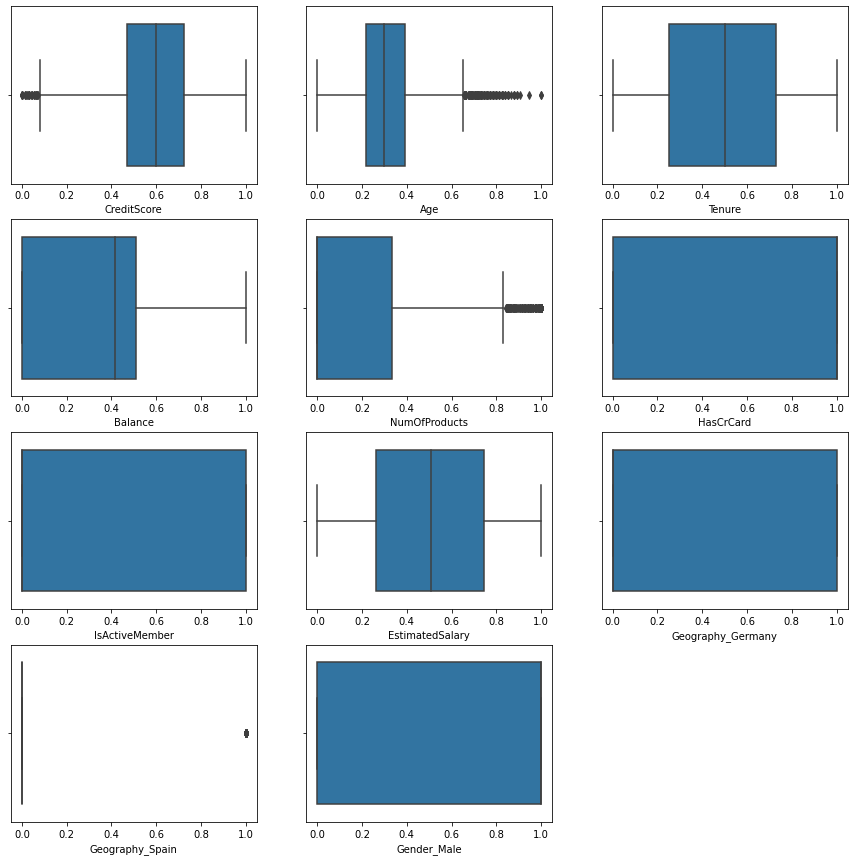

In [43]:
plot_boxplot(X)

* CreditScore - 
    * Outlier - <Q1 
    * Skew - Slightly right skewed
    * Distribution - Normal

* Age - 
    * Outlier - > Q3 (minimal)
    * Skew - Left skewed
    * Distribution - Normal
   
* Balance - 
    * Outlier - No outlier
    * Skew - Left skewed
    * Distribution - Kind of Normal when ignoring the outlier
   
* NumOfProducts - 
    * Outlier - >Q3 (minimal)
    * Skew - Left skewed
    * Distribution - Multiple distributions



In [44]:
# plot_histplot(X)

From the Box Plot and Distribution plot, can see that some of the variables has outliers and the distribution as well is not normal. 

Lets validate it statistically as well.

In [45]:
def estimate_outlier(column):
    Q1,Q3 = X[column].quantile(q=[0.25, 0.75])
    IQR = Q3 - Q1
    less_than_Q1 = X[column].apply(lambda x: 1 if x < (Q1 - 1.5*IQR) else 0)
    greater_than_Q3 = X[column].apply(lambda x: 1 if x > (Q3 + 1.5*IQR) else 0)
    
    total_values = X[column].shape[0]
    
    total_less_than_Q1 = np.sum(less_than_Q1)
    total_greater_than_Q3 = np.sum(greater_than_Q3)
    
    perc_less_than_Q1 = round((total_less_than_Q1 / total_values) * 100,2)
    perc_greater_than_Q3 = round((total_greater_than_Q3 / total_values) * 100,2)
    
    return { 'column': column, 'Outliers <Q1 (%)':perc_less_than_Q1, 'Outliers >Q3 (%)': perc_greater_than_Q3}
    

In [46]:
def estimate_skewness(column):
    skew = X[column].skew()
    skew_side = None
    if skew > 0 and skew > 0.05:
        skew_side = 'left'
    if skew < 0 and skew < -0.05:
        skew_side = 'right'
        
    return{'skew': skew, 'skew_side': skew_side}

In [47]:
def estimate_normality(column):
    distribution = None
    stat, p = shapiro(X[column])
    alpha = 0.05
    confidence_percent = 0.90
    if p > alpha and stat > confidence_percent:
        distribution = 'normal'
    else:
        distribution = 'not normal'
    return {'distribution': distribution}

In [48]:
data_analysis_list = []
for column in X.columns:
    data_analysis = {}
    outlier = estimate_outlier(column)
    skewness = estimate_skewness(column)
    normality = estimate_normality(column)
    data_analysis.update(outlier)
    data_analysis.update(skewness)
    data_analysis.update(normality)
    data_analysis_list.append(data_analysis)
    
data_analysis_df = pd.DataFrame.from_dict(data=data_analysis_list)
data_analysis_df

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,column,Outliers <Q1 (%),Outliers >Q3 (%),skew,skew_side,distribution
0,CreditScore,0.16,0.00,-0.060894,right,not normal
1,Age,0.00,1.57,0.567146,left,not normal
2,Tenure,0.00,0.00,0.024042,None,not normal
3,Balance,0.00,0.00,-0.310655,right,not normal
4,NumOfProducts,0.00,1.19,1.215044,left,not normal
5,HasCrCard,0.00,0.00,-0.893890,right,not normal
6,IsActiveMember,0.00,0.00,0.173972,left,not normal
7,EstimatedSalary,0.00,0.00,-0.019127,None,not normal
8,Geography_Germany,0.00,0.00,0.854386,left,not normal
9,Geography_Spain,0.00,23.33,1.261123,left,not normal


Outliers noticed for CreditScore, Age, NumOfProducts, Geography_Spain variables. 

Can ignore Geography_Spain as that was originally a categorical variable

For the rest, will set them to Q1/Q3 +/- 1.5*IQR

In [49]:
outlier_columns = ['CreditScore', 'Age', 'NumOfProducts']
for column in outlier_columns:
    q1, q2, q3 = X[column].quantile([0.25,0.5,0.75])
    IQR = q3 - q1
    upper_bound = (q3 + 1.5*IQR)
    lower_bound = (q1 - 1.5*IQR)
    X[column]=X[column].apply(lambda x: upper_bound if x>(upper_bound) else x)
    X[column]=X[column].apply(lambda x: lower_bound if x<(lower_bound) else x)

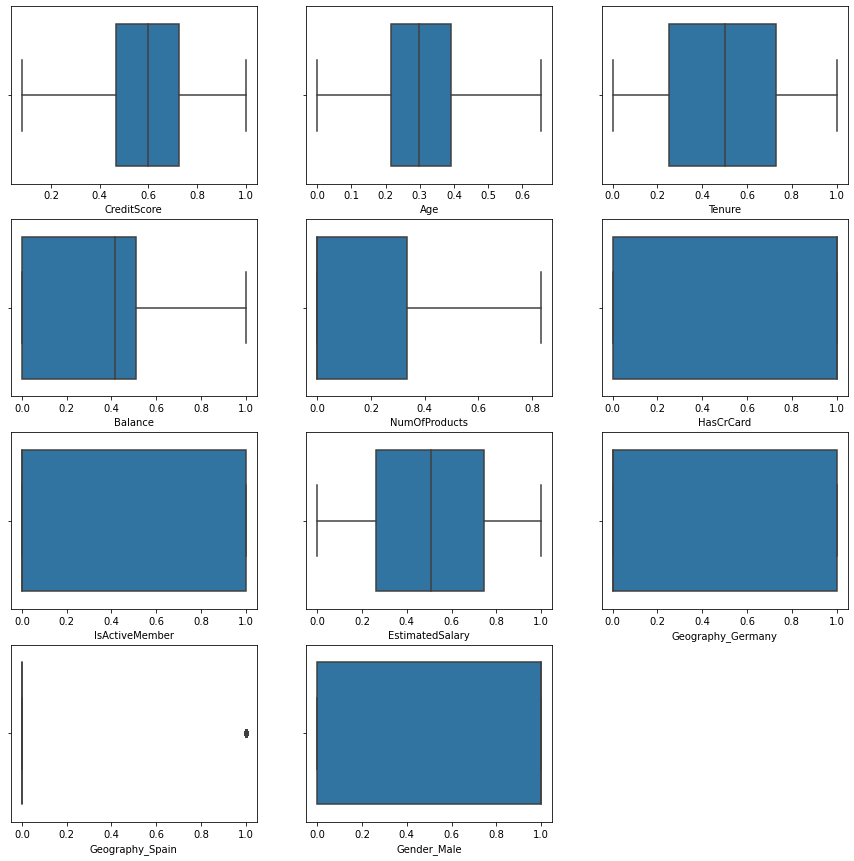

In [50]:
plot_boxplot(X)

Can see that the outliers are treated now. 

# Bivariate Analysis

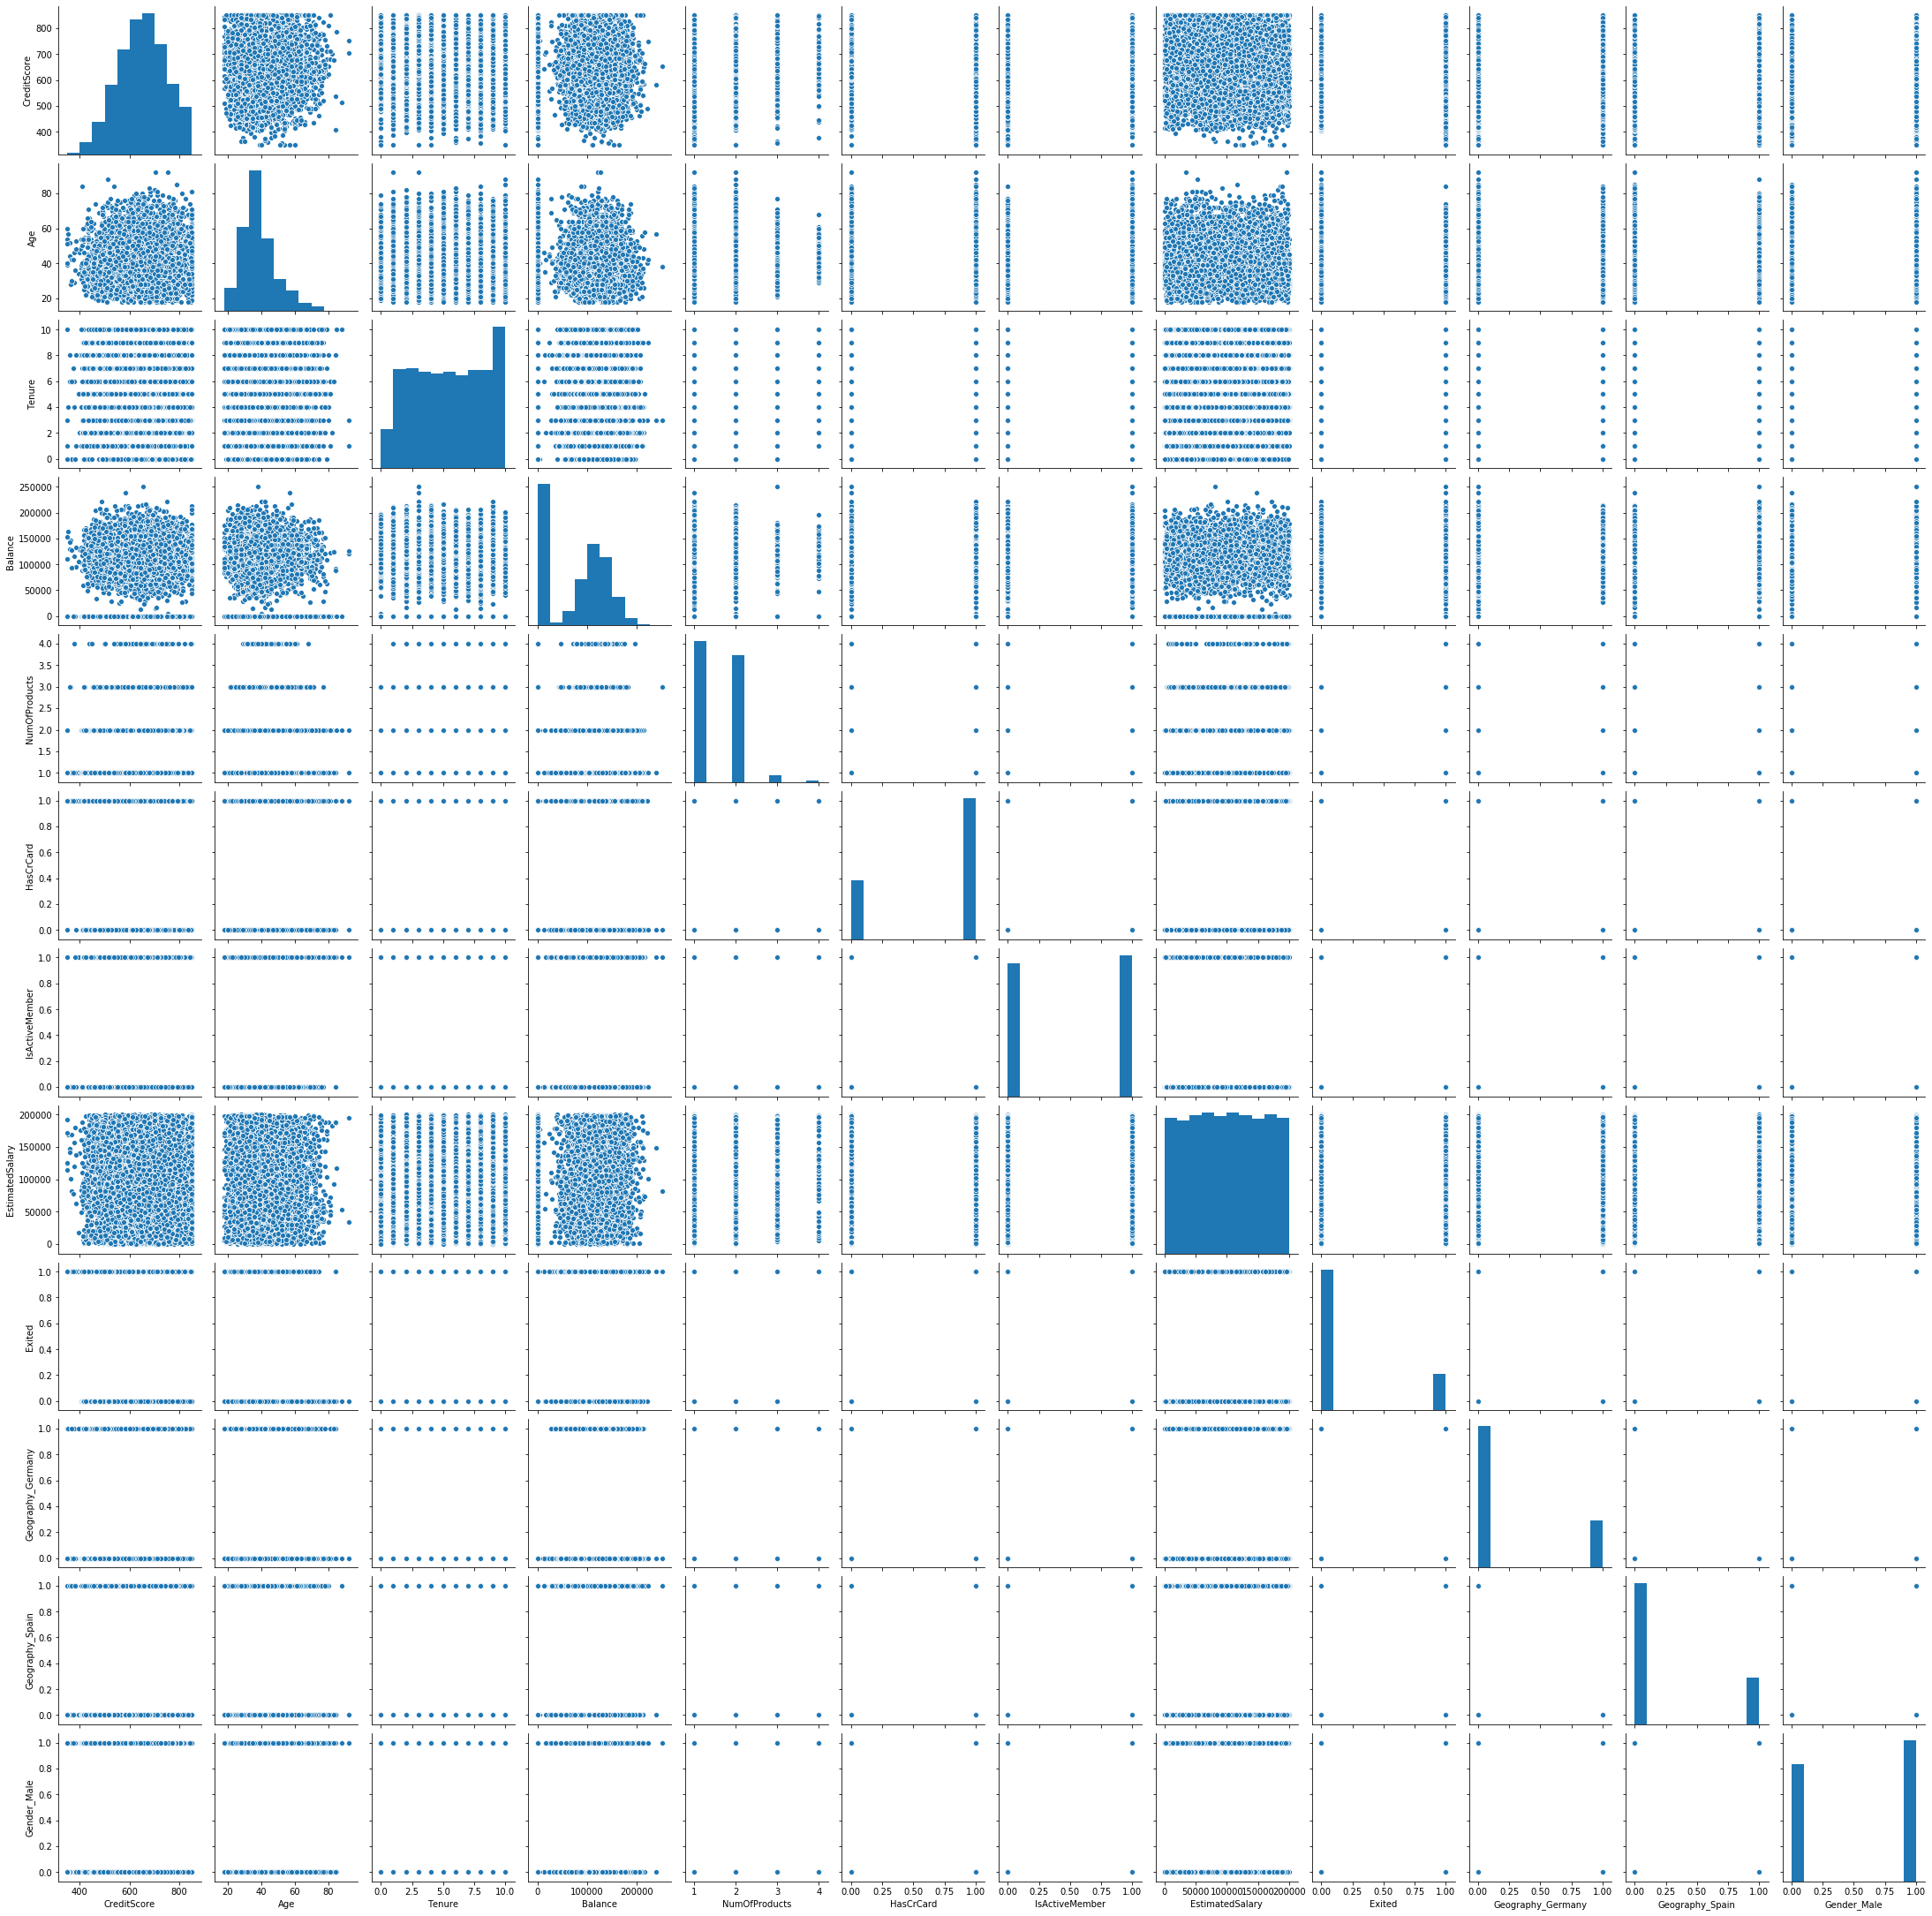

In [39]:
sns.pairplot(df)

Could not clearly identify if there are any highly correlated variables. 

Will do with printing the data

In [51]:
corr = df.corr()

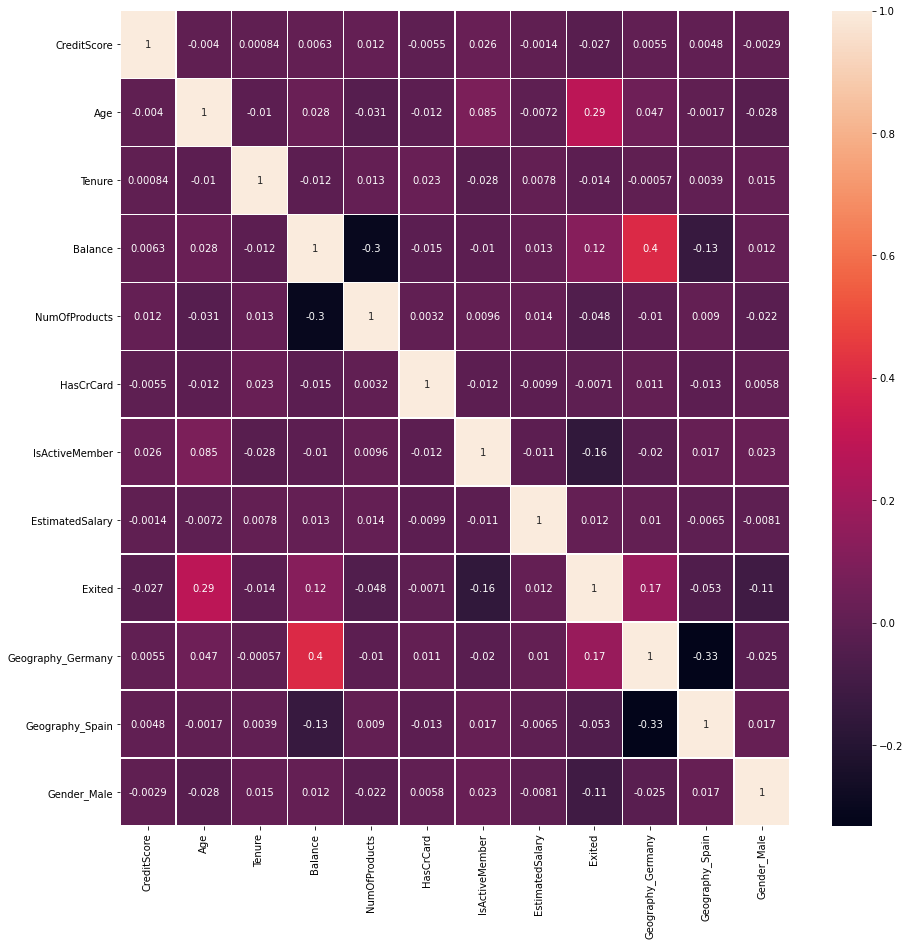

In [52]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

In [53]:
#Identifying the correlated variables if the correlation is > 0.4
#src_idx and target_idx will be used to make sure only the variables above diagonal are validated
#thereby unique set of variable combination is returned as output
corr_analysis = {}
corr_analysis_list = []
corr_threshold = 0.4 #Change it to different value, as required

columns = corr.columns
total_columns = len(columns)

for src_col_idx in range(1, total_columns):
    for tar_col_idx in range(1, total_columns):
        corr_analysis = {}
        src_col = columns[src_col_idx]
        tar_col = columns[tar_col_idx]
        corr_value = corr[src_col][tar_col]
        #Makes sure that the correlation for same src and target column is not considered
        #Makes sure that only the correlation values above diagonal are considered
        if (src_col_idx==1 or (src_col_idx > tar_col_idx)) and src_col_idx!=tar_col_idx:
            if np.abs(corr_value) > corr_threshold:
                if corr_value > 0:
                    trend = "positively"
                else:
                    trend = "negatively"
                corr_analysis['Source Column'] = src_col
                corr_analysis['Target Column'] = tar_col
                corr_analysis['Correlation'] = corr_value
                corr_analysis['Correlation trend'] = trend
                corr_analysis_list.append(corr_analysis)

print(f"Correlation Comparison with any value more than {corr_threshold}")
pd.DataFrame(corr_analysis_list)

Correlation Comparison with any value more than 0.4


,Source Column,Target Column,Correlation,Correlation trend
0,Geography_Germany,Balance,0.40111,positively


Can see that no column in highly correlated with one another apart from Geography_Germany & Balance. 

# Splitting the Data - Train , Validate & Test

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

In [55]:
y.shape

(15926, 1)

Converting the values as arrays, to be used in neural model

In [56]:
X_train = X_train.values
X_test = X_test.values
X_val = X_val.values
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

In [57]:
print(f"Training samples   = {X_train.shape[0]} ({round((X_train.shape[0]/X.shape[0])*100,2)}%)")
print(f"Test samples       = {X_test.shape[0]} ({round((X_test.shape[0]/X.shape[0])*100,2)}%)")
print(f"Validation samples = {X_val.shape[0]} ({round((X_val.shape[0]/X.shape[0])*100,2)}%)")

Training samples   = 10192 (64.0%)
Test samples       = 3186 (20.01%)
Validation samples = 2548 (16.0%)


In [58]:
X.to_csv("X.csv")

In [59]:
y.to_csv("y.csv")

In [60]:
X_temp = X.head(100)
y_temp = y.head(100)

In [61]:
X_temp.to_csv("X_temp.csv")
y_temp.to_csv("y_temp.csv")

## Using KerasNeuralFinder

In [9]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import time
import datetime
from sklearn.preprocessing import MinMaxScaler
import IPython
import os
import math
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc

In [10]:
X_temp = pd.read_csv("X_temp.csv").values
y_temp = pd.read_csv("y_temp.csv").values

In [11]:
y_temp = y_temp[:,-1]

In [12]:
import KerasOptimizerNN
from KerasOptimizerNN import KerasNeuralFinder

In [13]:
param_grid = {}
param_grid['hidden_layer_neurons'] =[[11, 8, 6]]
param_grid['output_layer_neurons'] = 1
param_grid['hidden_layer_activation'] = ['sigmoid']
param_grid['output_layer_activation'] = ['sigmoid']
param_grid['kernel_inializers'] = ['glorot_normal']
param_grid['bias_initializers'] = ['glorot_normal']
param_grid['optimizers'] = [ 'Adam', 'Nadam']
param_grid['epochs'] = [20]
param_grid['learning_rate'] = [0.01]
param_grid['loss_functions'] = ['binary_crossentropy']

In [14]:
knf = KerasNeuralFinder()
results = knf.fit(param_grid=param_grid, store_results=True, silent_mode=True, X=X_temp, y=y_temp, fold=2,
                  confidence_interval=80, metrics=['binary_accuracy', 'accuracy'])

There are around 2 choices based on the list of parameters defined
And it might take approximately 3.0 seconds assuming it would take 1.5 seconds for every epoch
Starting ...2
Choice 1/2..., epoch = 20
Choice 2/2..., epoch = 20
Completed running ... overall time taken = 6.25
Hyper parameter testing results saved to file - model_hp_results_.csv


In [15]:
results.T

,0,1
mean_loss,268.321,308.499
min_loss(80%),252.29,308.5
max_loss(80%),284.35,308.5
mean_binary_accuracy,80,80
min_binary_accuracy(80%),80,80
max_binary_accuracy(80%),80,80
mean_accuracy,80,80
min_accuracy(80%),80,80
max_accuracy(80%),80,80
mean_val_loss,268.762,308.499


In [8]:
KerasNeuralFinder.get_best_result(results).T

KeyError: 'loss'